# Recommender System Testing

The focus of this notebook is to test various code snippest, processing, subcomponents and integration of subcomponents for the recommender system

## Data Processing

External databases are initially used to test and train the recommender system so no actual pre-processing is required for that but when an online version is created and data is logged this will need to be processed and stored. For now the csv ratings file will be loaded and mappings will be created from user and movie ids to indexes. A sparse matrix will then be created to make indexing much easier, for this project double indexing will be done as it is more efficient than having a full sparse matrix.

In [1]:
import csv
import time
import os
import random
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
import optuna

train_ratio = 0.8
optuna_optimisation = False
# optuna_optimisation = True

external_data_path = "../data/external/"
image_path = "images/"

In [2]:
folder_name = external_data_path + "ml-latest-small"
file_name = "ratings.csv" 
file_path = os.path.join(folder_name, file_name)

# User and movie mappings
user_to_idx = {}
idx_to_user = {}
movie_to_idx = {}
idx_to_movie = {}

# Sparse Lists for user and movie ratings
user_ratings_train = []
user_ratings_test = []
movie_ratings_train = []
movie_ratings_test = []

test_count = 0
train_count = 0
start_time = time.time()
try:
    with open(file_path, 'r', newline='', encoding='utf-8') as csvfile:
        csv_reader = csv.reader(csvfile)
        header = next(csv_reader)
        for row in csv_reader:
            user_id = row[0]
            movie_id = row[1]
            rating = float(row[2])

            if user_id not in user_to_idx:
                user_idx = len(user_to_idx)
                user_to_idx[user_id] = user_idx
                idx_to_user[user_idx] = user_id
                user_ratings_test.append([])
                user_ratings_train.append([])

            if movie_id not in movie_to_idx:
                movie_idx = len(movie_to_idx)
                movie_to_idx[movie_id] = movie_idx
                idx_to_movie[movie_idx] = movie_id
                movie_ratings_train.append([]) 
                movie_ratings_test.append([])

            rand = random.random()
            if rand < 1:
                user_ratings_train[user_to_idx[user_id]].append((movie_to_idx[movie_id], rating))
                movie_ratings_train[movie_to_idx[movie_id]].append((user_to_idx[user_id], rating))
                train_count += 1
            else:
                user_ratings_test[user_to_idx[user_id]].append((movie_to_idx[movie_id], rating))
                movie_ratings_test[movie_to_idx[movie_id]].append((user_to_idx[user_id], rating))
                test_count += 1

except FileNotFoundError:
    print(f"File {file_path} not found.")
except Exception as e:
    print(f"An error occurred: {e}")

end_time = time.time()
print("Finished")
print("Time taken:", end_time - start_time, "seconds")

print("Train Count:", train_count)
print("Test Count:", test_count)

Finished
Time taken: 0.19251775741577148 seconds
Train Count: 100836
Test Count: 0


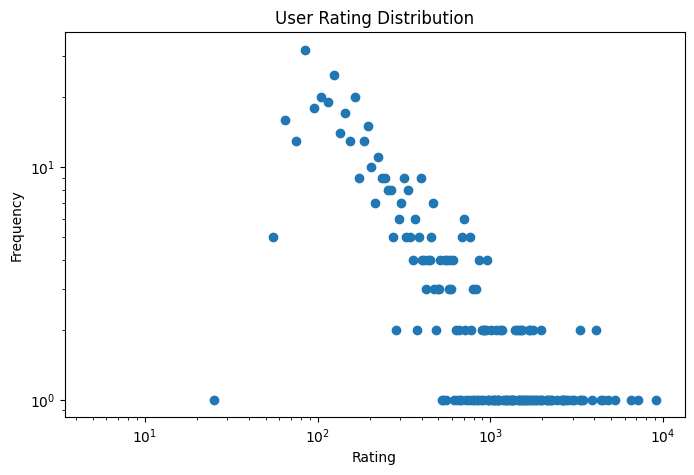

In [3]:
user_total_ratings = []

for row in user_ratings_train:
    user_sum = sum([rating for _, rating in row])
    user_total_ratings.append(user_sum)

all_user_ratings = [rating for rating in user_total_ratings]
user_rating_counts = Counter(all_user_ratings)
user_ratings = np.array(sorted(user_rating_counts.keys()))
user_frequencies = np.array([user_rating_counts[r] for r in user_ratings])

user_bin_edges = np.arange(0, max(user_total_ratings) + 10, 10)
user_frequencies, user_bins = np.histogram(user_total_ratings, bins=user_bin_edges)
user_bin_centers = 0.5 * (user_bins[1:] + user_bins[:-1])

plt.figure(figsize=(8,5))
plt.scatter(user_bin_centers, user_frequencies)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('User Rating Distribution')
plt.savefig(image_path + 'user_rating_distribution.svg')
plt.show()

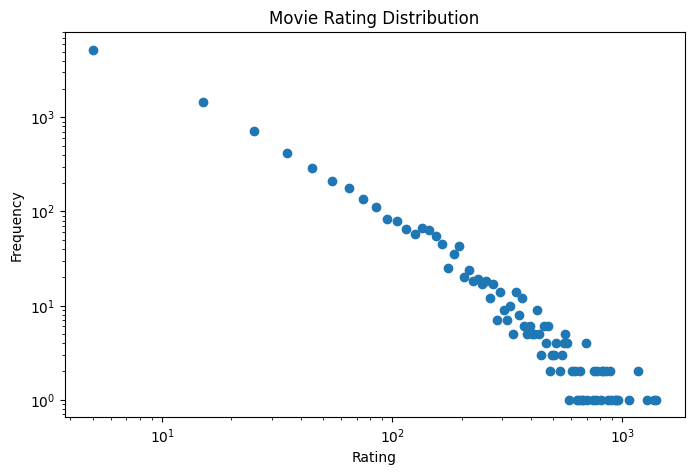

In [4]:
movie_total_ratings = []

for row in movie_ratings_train:
    movie_sum = sum([rating for _, rating in row])
    movie_total_ratings.append(movie_sum)

all_movie_ratings = [rating for rating in movie_total_ratings]
movie_rating_counts = Counter(all_movie_ratings)
movie_ratings = np.array(sorted(movie_rating_counts.keys()))
movie_frequencies = np.array([movie_rating_counts[r] for r in movie_ratings])

movie_bin_edges = np.arange(0, max(movie_total_ratings) + 10, 10)
movie_frequencies, movie_bins = np.histogram(movie_total_ratings, bins=movie_bin_edges)
movie_bin_centers = 0.5 * (movie_bins[1:] + movie_bins[:-1])

plt.figure(figsize=(8,5))
plt.scatter(movie_bin_centers, movie_frequencies)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Movie Rating Distribution')
plt.savefig(image_path + 'movie_rating_distribution.svg')
plt.show()

In [5]:
# --- Data Preprocessing (Unchanged) ---
# This function is efficient and does not need changes.
def preprocess_ratings(data):
    """Converts a list of lists of ratings into a flattened COO-like format."""
    all_x, all_y, all_r = [], [], []
    ptrs = [0]
    for i, ratings in enumerate(data):
        for j, r in ratings:
            all_x.append(i)
            all_y.append(j)
            all_r.append(r)
        ptrs.append(len(all_r))
    return (
        np.array(all_x, dtype=np.int32),
        np.array(all_y, dtype=np.int32),
        np.array(all_r, dtype=np.float64),
        np.array(ptrs, dtype=np.int32)
    )

## Bias Model 

In [6]:
min_ratings_per_movie = 50

# User and movie mappings
user_to_idx = {}
idx_to_user = {}
movie_to_idx = {}
idx_to_movie = {}

# Sparse Lists for user and movie ratings
user_ratings_train = []
user_ratings_test = []
movie_ratings_train = []
movie_ratings_test = []

test_count = 0
train_count = 0
start_time = time.time()

# First pass: count movie ratings
movie_rating_counts = {}

try:
    with open(file_path, 'r', newline='', encoding='utf-8') as csvfile:
        csv_reader = csv.reader(csvfile)
        header = next(csv_reader)
        for row in csv_reader:
            movie_id = row[1]
            movie_rating_counts[movie_id] = movie_rating_counts.get(movie_id, 0) + 1
except FileNotFoundError:
    print(f"File {file_path} not found.")
except Exception as e:
    print(f"An error occurred during first pass: {e}")

# Filter movies by rating count
valid_movies = {movie_id for movie_id, count in movie_rating_counts.items() if count >= min_ratings_per_movie}

# Second pass: process ratings
try:
    with open(file_path, 'r', newline='', encoding='utf-8') as csvfile:
        csv_reader = csv.reader(csvfile)
        header = next(csv_reader)
        for row in csv_reader:
            user_id = row[0]
            movie_id = row[1]
            rating = float(row[2])

            if movie_id not in valid_movies:
                continue  # Skip movies with too few ratings

            if user_id not in user_to_idx:
                user_idx = len(user_to_idx)
                user_to_idx[user_id] = user_idx
                idx_to_user[user_idx] = user_id
                user_ratings_train.append([])
                user_ratings_test.append([])

            if movie_id not in movie_to_idx:
                movie_idx = len(movie_to_idx)
                movie_to_idx[movie_id] = movie_idx
                idx_to_movie[movie_idx] = movie_id
                movie_ratings_train.append([])
                movie_ratings_test.append([])

            user_idx = user_to_idx[user_id]
            movie_idx = movie_to_idx[movie_id]

            user_seen_before = len(user_ratings_train[user_idx]) > 0
            movie_seen_before = len(movie_ratings_train[movie_idx]) > 0

            if not user_seen_before or not movie_seen_before or random.random() < train_ratio:
                # Assign to training set
                user_ratings_train[user_idx].append((movie_idx, rating))
                movie_ratings_train[movie_idx].append((user_idx, rating))
                train_count += 1
            else:
                # Assign to test set (only if both user and movie are known from training)
                user_ratings_test[user_idx].append((movie_idx, rating))
                movie_ratings_test[movie_idx].append((user_idx, rating))
                test_count += 1

except FileNotFoundError:
    print(f"File {file_path} not found.")
except Exception as e:
    print(f"An error occurred during second pass: {e}")

end_time = time.time()

# --- Logging ---
print("Finished")
print("Time taken:", round(end_time - start_time, 2), "seconds")
print("Train Count:", train_count)
print("Test Count:", test_count)
print("Unique Users:", len(user_to_idx))
print("Valid Movies (after filter):", len(movie_to_idx))


Finished
Time taken: 0.15 seconds
Train Count: 33326
Test Count: 8034
Unique Users: 606
Valid Movies (after filter): 450


In [7]:
# Hyperparameters
lam = 0.1
gamma = 0.1
num_epochs = 100

# Configure Biases
user_biases = np.zeros(len(user_ratings_train))
item_biases = np.zeros(len(movie_ratings_train))
training_loss = []
testing_loss = []
training_RMSE = []
testing_RMSE = []

# Estimate biases with loss function
for epoch in range(num_epochs):
    for u in range(len(user_ratings_train)):
        bias = 0
        counter = 0
        for movie_idx, rating in user_ratings_train[u]:
            bias += (rating - item_biases[movie_idx])
            counter += 1
        bias = lam * bias / ((lam * counter) + gamma)
        user_biases[u] = bias

    for m in range(len(movie_ratings_train)):
        bias = 0
        counter = 0
        for user_idx, rating in movie_ratings_train[m]:
            bias += (rating - user_biases[user_idx])
            counter += 1
        bias = lam * bias / ((lam * counter) + gamma)
        item_biases[m] = bias

    train_loss = 0
    count = 0
    train_error = 0
    for u, user_ratings in enumerate(user_ratings_train):
        for movie_idx, rating in user_ratings:
            pred = user_biases[u] + item_biases[movie_idx]
            train_error += (rating - pred) * (rating - pred)
            count += 1 
    train_rmse = np.sqrt(train_error / (count + 1e-10))
    train_loss = (lam * (train_error)) + (gamma * (np.sum(user_biases**2) + np.sum(item_biases**2)))
    training_loss.append(train_loss)
    training_RMSE.append(train_rmse)

    test_loss = 0
    test_error = 0
    count = 0
    for u, user_ratings in enumerate(user_ratings_test):
        for movie_idx, rating in user_ratings:
            pred = user_biases[u] + item_biases[movie_idx]
            test_error += (rating - pred) * (rating - pred)
            count += 1
    test_rmse = np.sqrt(test_error / (count + 1e-10))
    test_loss = (lam * (test_error)) + (gamma * (np.sum(user_biases**2) + np.sum(item_biases**2)))
    testing_RMSE.append(test_rmse)
    testing_loss.append(test_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {train_loss:.4f}, Train RMSE: {train_rmse:.4f}, Test RMSE: {test_rmse:.4f}")

Epoch 1/100, Loss: 3071.2972, Train RMSE: 0.8212, Test RMSE: 0.8518
Epoch 2/100, Loss: 2994.5224, Train RMSE: 0.8142, Test RMSE: 0.8447
Epoch 3/100, Loss: 2965.5674, Train RMSE: 0.8135, Test RMSE: 0.8438
Epoch 4/100, Loss: 2940.6535, Train RMSE: 0.8133, Test RMSE: 0.8435
Epoch 5/100, Loss: 2917.4816, Train RMSE: 0.8131, Test RMSE: 0.8433
Epoch 6/100, Loss: 2895.7308, Train RMSE: 0.8130, Test RMSE: 0.8432
Epoch 7/100, Loss: 2875.2888, Train RMSE: 0.8129, Test RMSE: 0.8430
Epoch 8/100, Loss: 2856.0739, Train RMSE: 0.8128, Test RMSE: 0.8429
Epoch 9/100, Loss: 2838.0118, Train RMSE: 0.8128, Test RMSE: 0.8428
Epoch 10/100, Loss: 2821.0335, Train RMSE: 0.8127, Test RMSE: 0.8427
Epoch 11/100, Loss: 2805.0738, Train RMSE: 0.8126, Test RMSE: 0.8426
Epoch 12/100, Loss: 2790.0717, Train RMSE: 0.8125, Test RMSE: 0.8425
Epoch 13/100, Loss: 2775.9696, Train RMSE: 0.8125, Test RMSE: 0.8425
Epoch 14/100, Loss: 2762.7137, Train RMSE: 0.8124, Test RMSE: 0.8424
Epoch 15/100, Loss: 2750.2531, Train RMSE: 

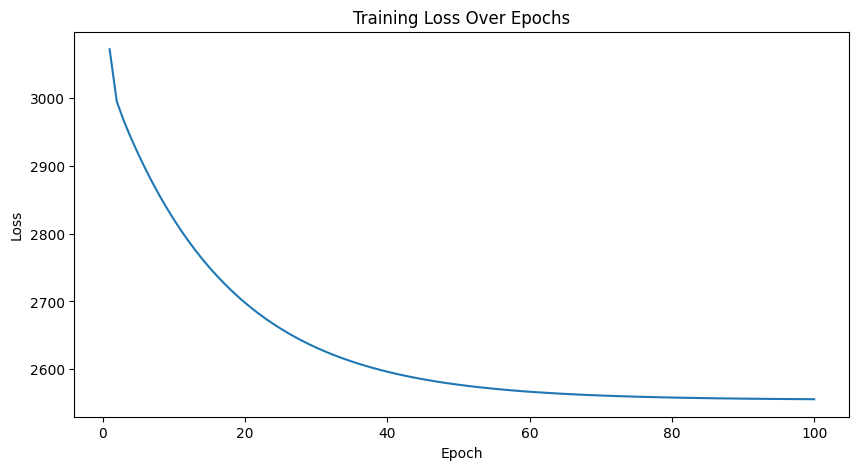

In [8]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), training_loss, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.savefig(image_path + 'bias_training_loss.svg')
plt.show()

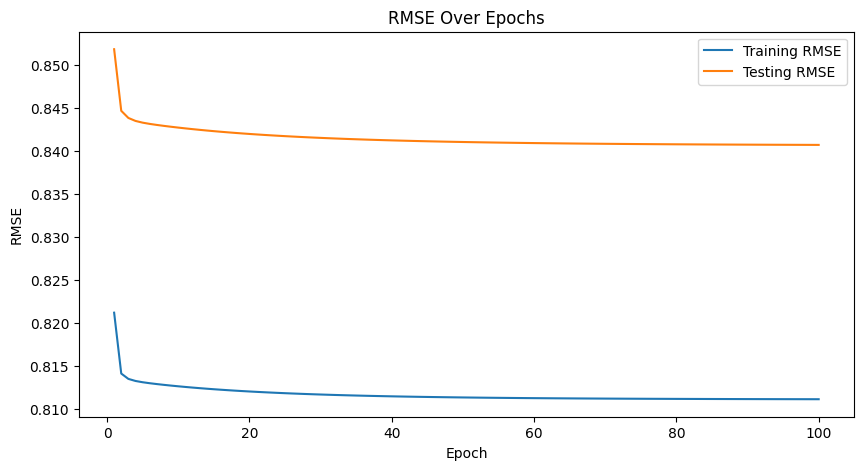

In [9]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), training_RMSE, label='Training RMSE')
plt.plot(range(1, num_epochs + 1), testing_RMSE, label='Testing RMSE')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.title('RMSE Over Epochs')
plt.savefig(image_path + 'bias_rmse.svg')
plt.show()

## Full Model

#### First Version

In [10]:
def training_old(num_epochs=100, lam=0.1, gamma=0.1, tau=0.1, embeddings_dim=20, scale=1):
    user_embeddings = np.random.normal(0, scale, (len(user_ratings_train), embeddings_dim))
    item_embeddings = np.random.normal(0, scale, (len(movie_ratings_train), embeddings_dim))
    user_biases = np.zeros(len(user_ratings_train))
    item_biases = np.zeros(len(movie_ratings_train))
    training_loss = []
    training_RMSE = []
    testing_RMSE = []

    for epoch in range(num_epochs):
        for u in range(len(user_ratings_train)):
            bias = 0
            counter = 0
            user = 0
            for movie_idx, rating in user_ratings_train[u]:
                bias += lam * (rating - ((user_embeddings[u].T @ item_embeddings[movie_idx]) + item_biases[movie_idx]))
                counter += 1
            bias = bias / ((lam * counter) + gamma)
            user_biases[u] = bias
            
            user_term = 0
            user_inverse_term = 0
            for movie_idx, rating in user_ratings_train[u]:
                user_inverse_term += lam * ((item_embeddings[movie_idx].T @ item_embeddings[movie_idx]) + (tau * np.eye(embeddings_dim)))
                user_term += lam * item_embeddings[movie_idx] * (rating - user_biases[u] - item_biases[movie_idx])
            user = np.linalg.solve(user_inverse_term, user_term)
            user_embeddings[u] = user

        for m in range(len(movie_ratings_train)):
            bias = 0
            counter = 0
            for user_idx, rating in movie_ratings_train[m]:
                bias += lam * (rating - ((user_embeddings[user_idx].T @ item_embeddings[m]) + user_biases[user_idx]))
                counter += 1
            bias = bias / ((lam * counter) + gamma)
            item_biases[m] = bias

            item_term = 0
            item_inverse_term = 0
            for user_idx, rating in movie_ratings_train[m]:
                item_inverse_term += lam * ((user_embeddings[user_idx].T @ user_embeddings[user_idx]) + (tau * np.eye(embeddings_dim)))
                item_term += lam * user_embeddings[user_idx] * (rating - user_biases[user_idx] - item_biases[m])
            item = np.linalg.solve(item_inverse_term, item_term)
            item_embeddings[m] = item

        train_loss = 0
        count = 0
        train_error = 0
        for u, user_ratings in enumerate(user_ratings_train):
            for movie_idx, rating in user_ratings:
                pred = (user_embeddings[u].T @ item_embeddings[movie_idx]) + user_biases[u] + item_biases[movie_idx]
                train_error += (rating - pred) * (rating - pred)
                count += 1 
        train_rmse = np.sqrt(train_error / (count + 1e-10))
        train_loss = (lam * (train_error)) \
            + (gamma * (np.sum(user_biases**2) + np.sum(item_biases**2))) \
            + (tau * (np.sum(user_embeddings.T @ user_embeddings) + np.sum(item_embeddings.T @ item_embeddings)))
        training_loss.append(train_loss)
        training_RMSE.append(train_rmse)

        test_error = 0
        count = 0
        for u, user_ratings in enumerate(user_ratings_test):
            for movie_idx, rating in user_ratings:
                pred = (user_embeddings[u].T @ item_embeddings[movie_idx]) + user_biases[u] + item_biases[movie_idx]
                test_error += (rating - pred) * (rating - pred)
                count += 1
        test_rmse = np.sqrt(test_error / (count + 1e-10))
        testing_RMSE.append(test_rmse)

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {train_loss:.4f}, Train RMSE: {train_rmse:.4f}, Test RMSE: {test_rmse:.4f}")

    return training_loss, training_RMSE, testing_RMSE, user_embeddings, item_embeddings

#### Optimised Version

In [11]:
def training_optimised(num_epochs=100, lam=0.1, gamma=0.1, tau=0.1, embeddings_dim=20, scale=1):
    user_embeddings = np.random.normal(0, scale, (len(user_ratings_train), embeddings_dim))
    item_embeddings = np.random.normal(0, scale, (len(movie_ratings_train), embeddings_dim))
    user_biases = np.zeros(len(user_ratings_train))
    item_biases = np.zeros(len(movie_ratings_train))
    training_loss = []
    training_RMSE = []
    testing_RMSE = []

    tau_identity = tau * np.eye(embeddings_dim)

    for epoch in range(num_epochs):
        for u in range(len(user_ratings_train)):
            counter = 0
            ratings = np.zeros(len(user_ratings_train[u]))
            pred = np.zeros(len(user_ratings_train[u]))
            for movie_idx, rating in user_ratings_train[u]:
                ratings[counter] = rating
                pred[counter] = ((user_embeddings[u].T @ item_embeddings[movie_idx]) + item_biases[movie_idx])
                counter += 1
            bias = lam * np.sum(ratings - pred)
            user_biases[u] = bias / ((lam * counter) + gamma)
            
            user_inverse_term = np.zeros((embeddings_dim, embeddings_dim))
            user_term = np.zeros(embeddings_dim)
            for movie_idx, rating in user_ratings_train[u]:
                item_vec = item_embeddings[movie_idx]
                user_inverse_term += np.outer(item_vec, item_vec)
                user_term += item_vec * (rating - user_biases[u] - item_biases[movie_idx])
            user_inverse_term = (lam * user_inverse_term) + tau_identity
            user_embeddings[u] = np.linalg.solve(user_inverse_term, lam * user_term)

        for m in range(len(movie_ratings_train)):
            counter = 0
            ratings = np.zeros(len(movie_ratings_train[m]))
            pred = np.zeros(len(movie_ratings_train[m]))
            for user_idx, rating in movie_ratings_train[m]:
                ratings[counter] = rating
                pred[counter] = ((user_embeddings[user_idx].T @ item_embeddings[m]) + user_biases[user_idx])
                counter += 1
            bias = lam * np.sum(ratings - pred)
            item_biases[m] = bias / ((lam * counter) + gamma)

            item_inverse_term = np.zeros((embeddings_dim, embeddings_dim))
            item_term = np.zeros(embeddings_dim)
            for user_idx, rating in movie_ratings_train[m]:
                user_vec = user_embeddings[user_idx]
                item_inverse_term += np.outer(user_vec, user_vec)
                item_term += user_vec * (rating - user_biases[user_idx] - item_biases[m])
            item_inverse_term = (lam * item_inverse_term) +  tau_identity
            item = np.linalg.solve(item_inverse_term, lam * item_term)
            item_embeddings[m] = item

        count = 0
        train_error = 0
        for u, user_ratings in enumerate(user_ratings_train):
            for movie_idx, rating in user_ratings:
                pred = (user_embeddings[u] @ item_embeddings[movie_idx]) + user_biases[u] + item_biases[movie_idx]
                train_error += (rating - pred) * (rating - pred)
                count += 1 
        train_rmse = np.sqrt(train_error / (count + 1e-10))
        train_loss = (lam * (train_error)) \
            + (gamma * (np.sum(user_biases**2) + np.sum(item_biases**2))) \
            + (tau * (np.sum(user_embeddings**2) + np.sum(item_embeddings**2)))
        training_loss.append(train_loss)
        training_RMSE.append(train_rmse)

        test_error = 0
        count = 0
        for u, user_ratings in enumerate(user_ratings_test):
            for movie_idx, rating in user_ratings:
                pred = (user_embeddings[u] @ item_embeddings[movie_idx]) + user_biases[u] + item_biases[movie_idx]
                test_error += (rating - pred) * (rating - pred)
                count += 1
        test_rmse = np.sqrt(test_error / (count + 1e-10))
        testing_RMSE.append(test_rmse)

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {train_loss:.4f}, Train RMSE: {train_rmse:.4f}, Test RMSE: {test_rmse:.4f}")

    return training_loss, training_RMSE, testing_RMSE, user_embeddings, item_embeddings

#### Optimised with Vectorisation

In [12]:
def training_optimised_vectorised(num_epochs=100, lam=0.1, gamma=0.1, tau=0.1, embeddings_dim=20, scale=1):
    num_users = len(user_ratings_train)
    num_items = len(movie_ratings_train)
    
    user_embeddings = np.random.normal(0, scale, (num_users, embeddings_dim))
    item_embeddings = np.random.normal(0, scale, (num_items, embeddings_dim))
    user_biases = np.zeros(num_users)
    item_biases = np.zeros(num_items)

    tau_identity = tau * np.eye(embeddings_dim)

    training_loss, training_RMSE, testing_RMSE = [], [], []

    for epoch in range(num_epochs):
        # USER UPDATE
        for u, ratings in enumerate(user_ratings_train):
            movies = np.array([idx for idx, _ in ratings], dtype=int)
            actual_ratings = np.array([r for _, r in ratings])

            item_vecs = item_embeddings[movies]
            item_bias = item_biases[movies]

            preds = (item_vecs @ user_embeddings[u]) + item_bias
            residuals = actual_ratings - preds

            user_biases[u] = lam * np.sum(residuals) / ((lam * len(ratings)) + gamma)

            adjusted_residuals = actual_ratings - user_biases[u] - item_bias
            user_inverse_term = lam * (item_vecs.T @ item_vecs) + tau_identity
            user_term = lam * (item_vecs.T @ adjusted_residuals)

            user_embeddings[u] = np.linalg.solve(user_inverse_term, user_term)

        # ITEM UPDATE
        for m, ratings in enumerate(movie_ratings_train):
            users = np.array([idx for idx, _ in ratings], dtype=int)
            actual_ratings = np.array([r for _, r in ratings])

            user_vecs = user_embeddings[users]
            user_bias = user_biases[users]

            preds = (user_vecs @ item_embeddings[m]) + user_bias
            residuals = actual_ratings - preds

            item_biases[m] = lam * np.sum(residuals) / ((lam * len(ratings)) + gamma)

            adjusted_residuals = actual_ratings - user_bias - item_biases[m]
            item_inverse_term = lam * (user_vecs.T @ user_vecs) + tau_identity
            item_term = lam * (user_vecs.T @ adjusted_residuals)

            item_embeddings[m] = np.linalg.solve(item_inverse_term, item_term)

        # --- Training RMSE ---
        train_preds, train_actuals = [], []
        for u, ratings in enumerate(user_ratings_train):
            movies = np.array([idx for idx, _ in ratings], dtype=int)
            actual_ratings = np.array([r for _, r in ratings])

            preds = (user_embeddings[u] @ item_embeddings[movies].T) + user_biases[u] + item_biases[movies]
            train_preds.append(preds)
            train_actuals.append(actual_ratings)

        train_preds = np.concatenate(train_preds)
        train_actuals = np.concatenate(train_actuals)

        train_error = np.sum((train_actuals - train_preds) ** 2)
        train_rmse = np.sqrt(train_error / len(train_actuals))

        train_loss = (lam * train_error) \
            + (gamma * (np.sum(user_biases ** 2) + np.sum(item_biases ** 2))) \
            + (tau * (np.sum(user_embeddings ** 2) + np.sum(item_embeddings ** 2)))
        
        training_loss.append(train_loss)
        training_RMSE.append(train_rmse)

        # --- Testing RMSE ---
        test_preds, test_actuals = [], []
        for u, ratings in enumerate(user_ratings_test):
            movies = np.array([idx for idx, _ in ratings], dtype=int)
            actual_ratings = np.array([r for _, r in ratings])

            preds = (user_embeddings[u] @ item_embeddings[movies].T) + user_biases[u] + item_biases[movies]
            test_preds.append(preds)
            test_actuals.append(actual_ratings)

        test_preds = np.concatenate(test_preds)
        test_actuals = np.concatenate(test_actuals)

        test_error = np.sum((test_actuals - test_preds) ** 2)
        test_rmse = np.sqrt(test_error / len(test_actuals))
        testing_RMSE.append(test_rmse)

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {train_loss:.4f}, Train RMSE: {train_rmse:.4f}, Test RMSE: {test_rmse:.4f}")

    return training_loss, training_RMSE, testing_RMSE, [user_embeddings, item_embeddings], [user_biases, item_biases] 


#### Numba Version

In [13]:
import numpy as np
from numba import njit, prange

# --- OPTIMIZED Numba-Accelerated Updates (Parallel) ---
@njit(parallel=True, cache=True)
def update_user_embeddings(num_users, user_ptrs, all_m, all_r,
                           user_embeddings, item_embeddings,
                           user_biases, item_biases,
                           lam, gamma, tau_identity):
    """
    Update user embeddings in parallel using the pre-calculated item embeddings.
    """
    dim = user_embeddings.shape[1]
    # This loop now runs in parallel across all available CPU cores
    for u in prange(num_users):
        start = user_ptrs[u]
        end = user_ptrs[u+1]
        n = end - start
        if n == 0:
            continue
            
        # Use fancy indexing to grab all necessary data at once
        movies = all_m[start:end]
        ratings = all_r[start:end]
        item_vecs = item_embeddings[movies]
        item_bias = item_biases[movies]
    
        # Perform vectorized prediction
        preds = item_vecs @ user_embeddings[u] + item_bias
        
        residuals = ratings - preds
        user_bias = lam * np.sum(residuals) / (lam * n + gamma)
        user_biases[u] = user_bias
    
        # Solve for the new embedding
        adjusted = ratings - user_bias - item_bias
        A = lam * (item_vecs.T @ item_vecs) + tau_identity
        b = lam * (item_vecs.T @ adjusted)
        user_embeddings[u] = np.linalg.solve(A, b)

@njit(parallel=True, cache=True)
def update_item_embeddings(num_items, item_ptrs, all_u, all_r,
                           user_embeddings, item_embeddings,
                           user_biases, item_biases,
                           lam, gamma, tau_identity):
    """
    Update item embeddings in parallel using the pre-calculated user embeddings.
    """
    dim = item_embeddings.shape[1]
    # This loop also runs in parallel
    for m in prange(num_items):
        start = item_ptrs[m]
        end = item_ptrs[m+1]
        n = end - start
        if n == 0:
            continue
            
        # Use fancy indexing
        users = all_u[start:end]
        ratings = all_r[start:end]
        user_vecs = user_embeddings[users]
        user_bias = user_biases[users]
        
        # Vectorized prediction
        preds = user_vecs @ item_embeddings[m] + user_bias
        
        residuals = ratings - preds
        item_bias = lam * np.sum(residuals) / (lam * n + gamma)
        item_biases[m] = item_bias
        
        # Solve for the new embedding
        adjusted = ratings - user_bias - item_bias
        A = lam * (user_vecs.T @ user_vecs) + tau_identity
        b = lam * (user_vecs.T @ adjusted)
        item_embeddings[m] = np.linalg.solve(A, b)

# --- OPTIMIZED JIT-compiled evaluation function (Parallel) ---
@njit(parallel=True, cache=True)
def calculate_rmse_jit(ptrs, all_user_indices, all_item_indices, all_ratings, 
                       user_embeddings, item_embeddings, user_biases, item_biases):
    """
    Calculates the Root Mean Squared Error in parallel.
    This function is generic and processes the data from a user-centric view.
    """
    total_squared_error = 0.0
    
    # Loop over all users in parallel
    for u in prange(len(ptrs) - 1):
        start, end = ptrs[u], ptrs[u+1]
        if start == end:
            continue
            
        item_idxs = all_item_indices[start:end]
        actuals = all_ratings[start:end]
        
        # Vectorized prediction for all items rated by this user
        preds = (user_embeddings[u] @ item_embeddings[item_idxs].T) + user_biases[u] + item_biases[item_idxs]
        
        # Numba automatically handles thread-safe summation for reduction operations
        total_squared_error += np.sum((actuals - preds) ** 2)

    return np.sqrt(total_squared_error / len(all_ratings))

# --- OPTIMIZED Main Training Function ---
def training_als_from_preprocessed(
    mu, 
    num_users, num_items,
    all_u_train, all_m_train, all_r_train_u, user_ptrs_train,
    all_m_rev_train, all_u_rev_train, all_r_train_m, item_ptrs_train,
    all_u_test, all_m_test, all_r_test, user_ptrs_test,
    num_epochs=20, lam=0.1, gamma=0.1, tau=0.1,
    embeddings_dim=20, scale=0.1
):
    """
    Optimized ALS training using preprocessed data.
    """
    print("Starting ALS optimization (preprocessed)...")
    start_time = time.time()

    user_embeddings = np.random.normal(0, scale, (num_users, embeddings_dim)).astype(np.float64)
    item_embeddings = np.random.normal(0, scale, (num_items, embeddings_dim)).astype(np.float64)
    user_biases = np.zeros(num_users, dtype=np.float64)
    item_biases = np.zeros(num_items, dtype=np.float64)
    tau_identity = np.ascontiguousarray(tau * np.eye(embeddings_dim, dtype=np.float64))

    training_RMSE, testing_RMSE = [], []
    training_loss = []

    for epoch in range(num_epochs):
        epoch_start = time.time()

        update_user_embeddings(num_users, user_ptrs_train, all_m_train, all_r_train_u,
                               user_embeddings, item_embeddings,
                               user_biases, item_biases,
                               lam, gamma, tau_identity)

        update_item_embeddings(num_items, item_ptrs_train, all_u_rev_train, all_r_train_m,
                               user_embeddings, item_embeddings,
                               user_biases, item_biases,
                               lam, gamma, tau_identity)

        train_rmse = calculate_rmse_jit(user_ptrs_train, all_u_train, all_m_train, all_r_train_u,
                                        user_embeddings, item_embeddings,
                                        user_biases, item_biases)

        test_rmse = calculate_rmse_jit(user_ptrs_test, all_u_test, all_m_test, all_r_test,
                                       user_embeddings, item_embeddings,
                                       user_biases, item_biases)

        squared_user_bias = np.sum(user_biases**2)
        squared_item_bias = np.sum(item_biases**2)

        # Frobenius norms of embedding matrices
        embedding_user_norm = np.sum(user_embeddings * user_embeddings)
        embedding_item_norm = np.sum(item_embeddings * item_embeddings)

        train_loss = (
            lam * train_rmse**2 * len(all_r_train_u)
            + gamma * (squared_user_bias + squared_item_bias)
            + tau * (embedding_user_norm + embedding_item_norm)
        )

        training_RMSE.append(train_rmse)
        testing_RMSE.append(test_rmse)
        training_loss.append(train_loss)

        print(f"Epoch {epoch+1}/{num_epochs} | Train RMSE: {train_rmse:.4f} | Test RMSE: {test_rmse:.4f} | Time: {time.time() - epoch_start:.2f}s")

    print(f"Finished training. Total time: {time.time() - start_time:.2f}s")

    return training_loss, training_RMSE, testing_RMSE, [user_embeddings, item_embeddings], [user_biases, item_biases]

## Optuna Section

In [14]:
folder_name = external_data_path + "ml-32m"
file_name = "ratings.csv" 
file_path = os.path.join(folder_name, file_name)

In [15]:
min_ratings_per_movie = 50

# User and movie mappings
user_to_idx = {}
idx_to_user = {}
movie_to_idx = {}
idx_to_movie = {}

# Sparse Lists for user and movie ratings
user_ratings_train = []
user_ratings_test = []
movie_ratings_train = []
movie_ratings_test = []

test_count = 0
train_count = 0
start_time = time.time()

# First pass: count movie ratings
movie_rating_counts = {}

try:
    with open(file_path, 'r', newline='', encoding='utf-8') as csvfile:
        csv_reader = csv.reader(csvfile)
        header = next(csv_reader)
        for row in csv_reader:
            movie_id = row[1]
            movie_rating_counts[movie_id] = movie_rating_counts.get(movie_id, 0) + 1
except FileNotFoundError:
    print(f"File {file_path} not found.")
except Exception as e:
    print(f"An error occurred during first pass: {e}")

# Filter movies by rating count
valid_movies = {movie_id for movie_id, count in movie_rating_counts.items() if count >= min_ratings_per_movie}

# Second pass: process ratings
try:
    with open(file_path, 'r', newline='', encoding='utf-8') as csvfile:
        csv_reader = csv.reader(csvfile)
        header = next(csv_reader)
        for row in csv_reader:
            user_id = row[0]
            movie_id = row[1]
            rating = float(row[2])

            if movie_id not in valid_movies:
                continue  # Skip movies with too few ratings

            if user_id not in user_to_idx:
                user_idx = len(user_to_idx)
                user_to_idx[user_id] = user_idx
                idx_to_user[user_idx] = user_id
                user_ratings_train.append([])
                user_ratings_test.append([])

            if movie_id not in movie_to_idx:
                movie_idx = len(movie_to_idx)
                movie_to_idx[movie_id] = movie_idx
                idx_to_movie[movie_idx] = movie_id
                movie_ratings_train.append([])
                movie_ratings_test.append([])

            user_idx = user_to_idx[user_id]
            movie_idx = movie_to_idx[movie_id]

            user_seen_before = len(user_ratings_train[user_idx]) > 0
            movie_seen_before = len(movie_ratings_train[movie_idx]) > 0

            if not user_seen_before or not movie_seen_before or random.random() < train_ratio:
                # Assign to training set
                user_ratings_train[user_idx].append((movie_idx, rating))
                movie_ratings_train[movie_idx].append((user_idx, rating))
                train_count += 1
            else:
                # Assign to test set (only if both user and movie are known from training)
                user_ratings_test[user_idx].append((movie_idx, rating))
                movie_ratings_test[movie_idx].append((user_idx, rating))
                test_count += 1

except FileNotFoundError:
    print(f"File {file_path} not found.")
except Exception as e:
    print(f"An error occurred during second pass: {e}")

end_time = time.time()

# --- Logging ---
print("Finished")
print("Time taken:", round(end_time - start_time, 2), "seconds")
print("Train Count:", train_count)
print("Test Count:", test_count)
print("Unique Users:", len(user_to_idx))
print("Valid Movies (after filter):", len(movie_to_idx))


Finished
Time taken: 80.3 seconds
Train Count: 25241762
Test Count: 6256927
Unique Users: 200947
Valid Movies (after filter): 16034


In [16]:
file_name = "movies.csv" 
file_path = os.path.join(folder_name, file_name)

movie_id_to_movie_name = {}
movie_name_to_movie_id = {}

try:
    with open(file_path, 'r', newline='', encoding='utf-8') as csvfile:
        csv_reader = csv.reader(csvfile)
        header = next(csv_reader)
        for row in csv_reader:
            movie_id = row[0]
            movie_name = row[1]

            if movie_id not in movie_id_to_movie_name:
                movie_id_to_movie_name[movie_id] = movie_name
                movie_name_to_movie_id[movie_name] = movie_id

except FileNotFoundError:
    print(f"File {file_path} not found.")
except Exception as e:
    print(f"An error occurred: {e}")

In [17]:
all_u_train, all_m_train, all_r_train_u, user_ptrs_train = preprocess_ratings(user_ratings_train)
all_m_rev_train, all_u_rev_train, all_r_train_m, item_ptrs_train = preprocess_ratings(movie_ratings_train)
all_u_test, all_m_test, all_r_test, user_ptrs_test = preprocess_ratings(user_ratings_test)

num_users = len(user_ratings_train)
num_items = len(movie_ratings_train)

ratings_mean = np.mean(all_r_train_u)

In [18]:
def objective(trial):
    lam = trial.suggest_float('lam', 1e-1, 10.0, log=True)
    gamma = trial.suggest_float('gamma', 1e-1, 10.0, log=True)
    tau = trial.suggest_float('tau', 1e-1, 10.0, log=True)
    embeddings_dim = trial.suggest_int('embeddings_dim', 10, 30)
    scale = trial.suggest_float('scale', 0.01, 1.0)

    num_epochs = 20
    
    training_RMSE, testing_RMSE, _, _ = training_als_from_preprocessed(
        ratings_mean,
        num_users, num_items,
        all_u_train, all_m_train, all_r_train_u, user_ptrs_train,
        all_m_rev_train, all_u_rev_train, all_r_train_m, item_ptrs_train,
        all_u_test, all_m_test, all_r_test, user_ptrs_test,
        num_epochs=10, lam=lam, gamma=gamma, tau=tau,
        embeddings_dim=embeddings_dim, scale=scale
    )

    return testing_RMSE[-1]

In [19]:
storage_name = "sqlite:///optuna_study.db"  # File-based SQLite DB
study_name = "matrix_factorization_study"

# Define these before the block if needed
best_params = {}
best_rmse = 0

# === Run optimization or load from file ===
if optuna_optimisation:
    # Create or load study from SQLite DB
    study = optuna.create_study(
        study_name=study_name,
        direction='minimize',
        pruner=optuna.pruners.MedianPruner(),
        storage=storage_name,
        load_if_exists=True
    )
    
    # Optimize the objective function
    study.optimize(objective, n_trials=100)

    best_params = study.best_params
    best_rmse = study.best_value

    # Save best params to text file for human-readable record
    with open('best_hyperparams.txt', 'w') as f:
        for param, value in best_params.items():
            f.write(f"{param}: {value}\n")
        f.write(f"Best Test RMSE: {best_rmse}\n")

else:
    # Load best params from text file if not running optimization
    if os.path.exists('best_hyperparams.txt'):
        with open('best_hyperparams.txt', 'r') as f:
            for line in f:
                if ':' in line:
                    key, value = line.strip().split(':')
                    key = key.strip()
                    value = value.strip()
                    if key == 'Best Test RMSE':
                        best_rmse = float(value)
                    else:
                        try:
                            value = int(value)
                        except ValueError:
                            try:
                                value = float(value)
                            except ValueError:
                                pass
                        best_params[key] = value
    else:
        raise FileNotFoundError("best_hyperparams.txt not found. Run with optuna_optimisation=True first.")

print("Best Hyperparameters:", best_params)
print("Best Test RMSE:", best_rmse)


Best Hyperparameters: {'lam': 0.2967578122000694, 'gamma': 0.21104871252319177, 'tau': 7.536619368542641, 'embeddings_dim': 20, 'scale': 0.4123235301422883}
Best Test RMSE: 0.7733958234618036


## Training Implementation

In [20]:
lam = 0.1
gamma = 0.1
tau = 0.1
scale = 1.0  # or any fixed value you want

# Values to test for embedding dimension
embedding_dims = [5, 10, 15, 20, 30, 40]

test_rmses = []
train_rmses = []
training_loss = []
for dim in embedding_dims:
    training_loss, training_RMSE, testing_RMSE, _, _ = training_als_from_preprocessed(
        ratings_mean,
        num_users, num_items,
        all_u_train, all_m_train, all_r_train_u, user_ptrs_train,
        all_m_rev_train, all_u_rev_train, all_r_train_m, item_ptrs_train,
        all_u_test, all_m_test, all_r_test, user_ptrs_test,
        num_epochs=20, lam=lam, gamma=gamma, tau=tau,
        embeddings_dim=dim, scale=scale/dim
    )

    print(f"embedding_dim={dim} => Test RMSE: {testing_RMSE[-1]:.4f}")
    test_rmses.append(testing_RMSE)
    train_rmses.append(training_RMSE)
    training_loss.append(training_loss)


Starting ALS optimization (preprocessed)...
Epoch 1/20 | Train RMSE: 0.8413 | Test RMSE: 0.8805 | Time: 39.89s
Epoch 2/20 | Train RMSE: 0.8006 | Test RMSE: 0.8451 | Time: 1.57s
Epoch 3/20 | Train RMSE: 0.7758 | Test RMSE: 0.8206 | Time: 1.36s
Epoch 4/20 | Train RMSE: 0.7636 | Test RMSE: 0.8086 | Time: 1.84s
Epoch 5/20 | Train RMSE: 0.7574 | Test RMSE: 0.8024 | Time: 1.79s
Epoch 6/20 | Train RMSE: 0.7539 | Test RMSE: 0.7988 | Time: 1.50s
Epoch 7/20 | Train RMSE: 0.7518 | Test RMSE: 0.7968 | Time: 1.44s
Epoch 8/20 | Train RMSE: 0.7506 | Test RMSE: 0.7956 | Time: 1.30s
Epoch 9/20 | Train RMSE: 0.7497 | Test RMSE: 0.7949 | Time: 1.13s
Epoch 10/20 | Train RMSE: 0.7491 | Test RMSE: 0.7944 | Time: 1.27s
Epoch 11/20 | Train RMSE: 0.7487 | Test RMSE: 0.7940 | Time: 1.30s
Epoch 12/20 | Train RMSE: 0.7483 | Test RMSE: 0.7937 | Time: 1.21s
Epoch 13/20 | Train RMSE: 0.7480 | Test RMSE: 0.7935 | Time: 1.18s
Epoch 14/20 | Train RMSE: 0.7477 | Test RMSE: 0.7932 | Time: 1.26s
Epoch 15/20 | Train RMSE: 

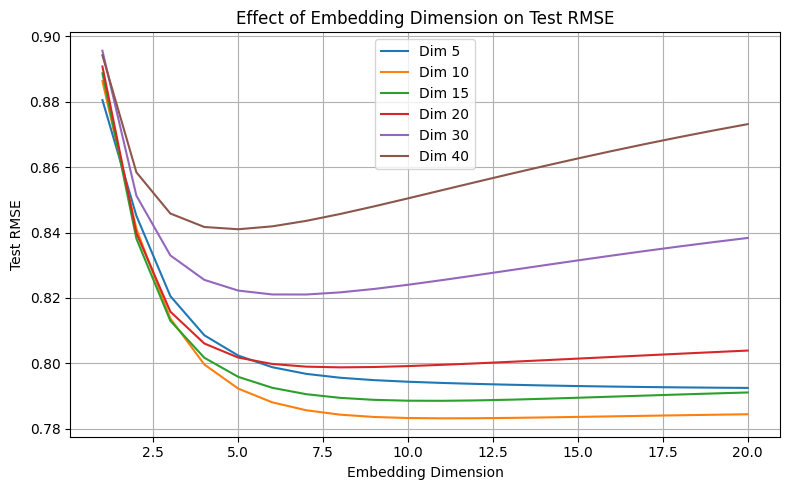

In [21]:
plt.figure(figsize=(8, 5))
for i in range(len(embedding_dims)):
    plt.plot(range(1, 21), test_rmses[i])
plt.xlabel('Embedding Dimension')
plt.ylabel('Test RMSE')
plt.title('Effect of Embedding Dimension on Test RMSE')
plt.grid(True)
plt.legend([f"Dim {dim}" for dim in embedding_dims])
plt.tight_layout()
plt.savefig(image_path + 'embeddings_test_loss.svg')
plt.show()

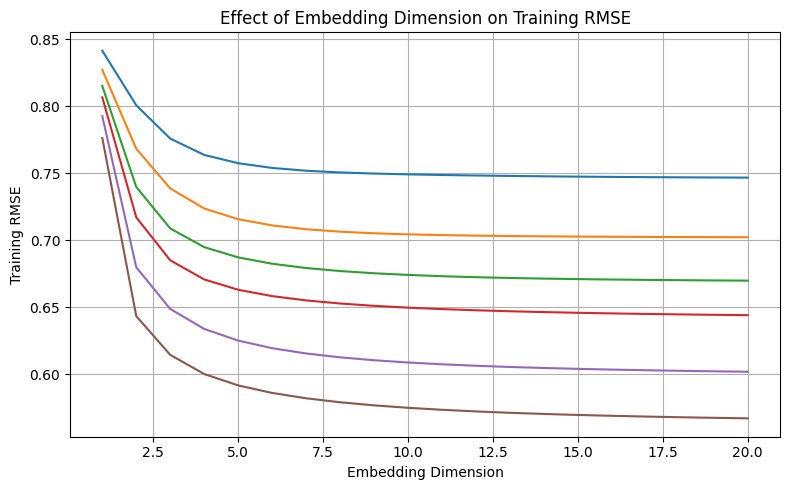

In [22]:
plt.figure(figsize=(8, 5))
for i in range(len(embedding_dims)):
    plt.plot(range(1, 21), train_rmses[i])
plt.xlabel('Embedding Dimension')
plt.ylabel('Training RMSE')
plt.title('Effect of Embedding Dimension on Training RMSE')
plt.grid(True)
plt.tight_layout()
plt.savefig(image_path + 'embedding_trianing_loss.svg')
plt.show()

In [23]:
lam = 0.1
gamma = 0.1
tau = 2
embeddings_dim = 10
scale = 1/embeddings_dim

In [24]:
num_epochs = 50

training_loss, training_RMSE, testing_RMSE, embeddings, biases = training_als_from_preprocessed(
        ratings_mean,
        num_users, num_items,
        all_u_train, all_m_train, all_r_train_u, user_ptrs_train,
        all_m_rev_train, all_u_rev_train, all_r_train_m, item_ptrs_train,
        all_u_test, all_m_test, all_r_test, user_ptrs_test,
        num_epochs=num_epochs, lam=lam, gamma=gamma, tau=tau,
        embeddings_dim=embeddings_dim, scale=scale
    )

Starting ALS optimization (preprocessed)...
Epoch 1/50 | Train RMSE: 0.8453 | Test RMSE: 0.8701 | Time: 1.71s
Epoch 2/50 | Train RMSE: 0.7742 | Test RMSE: 0.8251 | Time: 1.66s
Epoch 3/50 | Train RMSE: 0.7460 | Test RMSE: 0.7988 | Time: 1.64s
Epoch 4/50 | Train RMSE: 0.7346 | Test RMSE: 0.7879 | Time: 1.63s
Epoch 5/50 | Train RMSE: 0.7293 | Test RMSE: 0.7830 | Time: 1.65s
Epoch 6/50 | Train RMSE: 0.7267 | Test RMSE: 0.7805 | Time: 1.64s
Epoch 7/50 | Train RMSE: 0.7253 | Test RMSE: 0.7792 | Time: 1.66s
Epoch 8/50 | Train RMSE: 0.7244 | Test RMSE: 0.7784 | Time: 1.62s
Epoch 9/50 | Train RMSE: 0.7237 | Test RMSE: 0.7778 | Time: 1.61s
Epoch 10/50 | Train RMSE: 0.7233 | Test RMSE: 0.7774 | Time: 1.64s
Epoch 11/50 | Train RMSE: 0.7229 | Test RMSE: 0.7771 | Time: 1.64s
Epoch 12/50 | Train RMSE: 0.7226 | Test RMSE: 0.7768 | Time: 1.61s
Epoch 13/50 | Train RMSE: 0.7224 | Test RMSE: 0.7766 | Time: 1.62s
Epoch 14/50 | Train RMSE: 0.7222 | Test RMSE: 0.7764 | Time: 1.65s
Epoch 15/50 | Train RMSE: 0

In [25]:
bias = np.array(biases[1])  # ensure it's a NumPy array for indexing
top_10_indices = np.argsort(-bias)[:10]  # negative for descending sort
top_10_values = bias[top_10_indices]

# If you want both as a list of (index, value) pairs:
top_10_pairs = list(zip(top_10_indices, top_10_values))

for index, value in top_10_pairs:
    print(f"Movie: {movie_id_to_movie_name[idx_to_movie[index]]}, Bias: {value:.4f}")

Movie: Planet Earth II (2016), Bias: 1.9817
Movie: Planet Earth (2006), Bias: 1.9620
Movie: An Elephant Sitting Still (2018), Bias: 1.9148
Movie: Twelve Angry Men (1954), Bias: 1.9092
Movie: Blue Planet II (2017), Bias: 1.8737
Movie: Band of Brothers (2001), Bias: 1.8671
Movie: Once Brothers (2010), Bias: 1.8620
Movie: Cosmos, Bias: 1.8490
Movie: The Blue Planet (2001), Bias: 1.8477
Movie: Human Condition III, The (Ningen no joken III) (1961), Bias: 1.8358


In [26]:
save_dir = os.path.join("..", "models")
os.makedirs(save_dir, exist_ok=True)
save_path = os.path.join(save_dir, "recommender_model_params.npz")

np.savez_compressed(
    save_path,
    user_embeddings=embeddings[0],
    item_embeddings=embeddings[1],
    user_biases=biases[0],
    item_biases=biases[1]
)

50


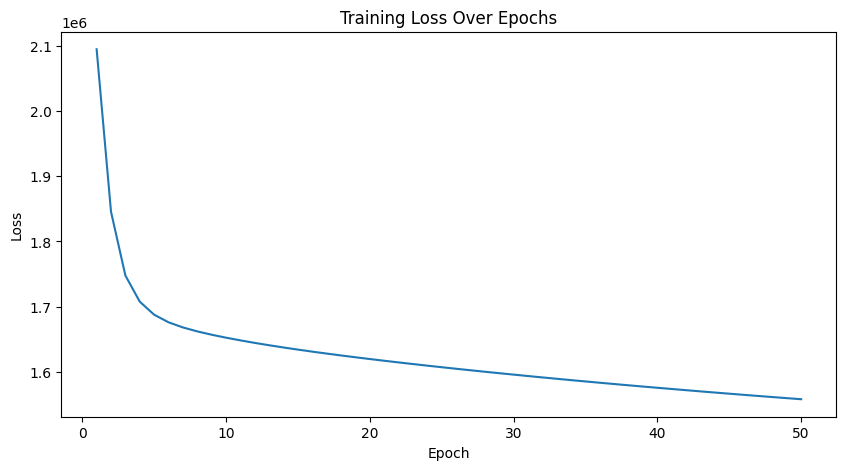

In [27]:
print(len(training_loss))
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), training_loss, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.savefig(image_path + 'large_full_model_trianing_loss.svg')
plt.show()

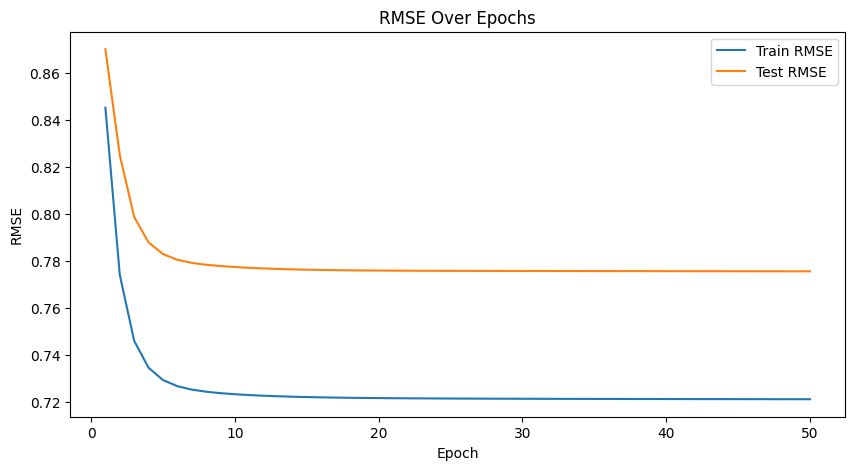

In [28]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), training_RMSE, label='Train RMSE')
plt.plot(range(1, num_epochs + 1), testing_RMSE, label='Test RMSE')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.title('RMSE Over Epochs')
plt.savefig(image_path + 'large_full_model_rmse.svg')
plt.show()

## Evaluation

In [29]:
save_dir = os.path.join("..", "models")
save_path = os.path.join(save_dir, "recommender_model_params.npz")

# Load the model parameters
with np.load(save_path, allow_pickle=True) as data:
    user_embeddings = data['user_embeddings']
    item_embeddings = data['item_embeddings']
    user_biases = data['user_biases']
    item_biases = data['item_biases']

print("User Embeddings Shape:", user_embeddings.shape)
print("Item Embeddings Shape:", item_embeddings.shape)
print("User Biases Shape:", user_biases.shape)
print("Item Biases Shape:", item_biases.shape)

User Embeddings Shape: (200947, 10)
Item Embeddings Shape: (16034, 10)
User Biases Shape: (200947,)
Item Biases Shape: (16034,)


In [30]:
print(np.linalg.norm(user_embeddings, axis=1))
# Compute L2 norm of each movie's embedding vector
movie_norms = np.linalg.norm(item_embeddings, axis=1)

# Get top 10 movie indices with highest norms
top_10_indices = np.argsort(-movie_norms)[:10]  # descending sort
top_10_values = movie_norms[top_10_indices]

# If you want both as a list of (index, value) pairs:
top_10_pairs = list(zip(top_10_indices, top_10_values))

for index, value in top_10_pairs:
    print(f"Movie: {movie_id_to_movie_name[idx_to_movie[index]]}, Norm: {value:.4f}")


[0.7597408  0.55445439 0.5595763  ... 0.34180737 0.38406123 0.51844571]
Movie: Lord of the Rings: The Return of the King, The (2003), Norm: 7.5399
Movie: Lord of the Rings: The Two Towers, The (2002), Norm: 7.4090
Movie: Lord of the Rings: The Fellowship of the Ring, The (2001), Norm: 7.4011
Movie: Dumb & Dumber (Dumb and Dumber) (1994), Norm: 7.3335
Movie: Star Wars: Episode IV - A New Hope (1977), Norm: 7.3056
Movie: Star Wars: Episode I - The Phantom Menace (1999), Norm: 7.0587
Movie: Star Wars: Episode V - The Empire Strikes Back (1980), Norm: 6.8727
Movie: Star Wars: Episode VI - Return of the Jedi (1983), Norm: 6.7903
Movie: Star Wars: Episode II - Attack of the Clones (2002), Norm: 6.7860
Movie: Ace Ventura: Pet Detective (1994), Norm: 6.5530


In [34]:
user_id = "dummy_user"
movie_id = "2116"
rating = 5

user_idx = len(user_to_idx)
user_to_idx[user_id] = user_idx
idx_to_user[user_idx] = user_id
movie = movie_to_idx[movie_id]

In [35]:
num_epochs = 100
embeddings_dim = 10

dummy_user_embedding = np.random.normal(0, scale, embeddings_dim)
dummy_user_bias = 0
movie_embedding = item_embeddings[movie]
movie_bias = item_biases[movie]

tau_identity = tau * np.eye(embeddings_dim)

training_loss, training_RMSE, testing_RMSE = [], [], []

for epoch in range(num_epochs):
    actual_rating = rating
    pred = (dummy_user_embedding @ movie_embedding) + dummy_user_bias + movie_bias
    residual = actual_rating - pred

    dummy_user_bias = lam * residual / ((lam * 1) + gamma)

    adjusted_residual = actual_rating - dummy_user_bias - movie_bias
    user_inverse_term = lam * np.outer(movie_embedding, movie_embedding) + tau_identity
    user_term = lam * (movie_embedding * adjusted_residual)

    dummy_user_embedding = np.linalg.solve(user_inverse_term, user_term)

    pred = (dummy_user_embedding @ movie_embedding) + dummy_user_bias + movie_bias
    train_error = actual_rating - pred
    train_loss = (lam * train_error ** 2) \
        + (gamma * (np.sum(dummy_user_bias ** 2) + np.sum(item_biases[movie] ** 2))) \
        + (tau * (np.sum(dummy_user_embedding ** 2) + np.sum(item_embeddings[movie] ** 2)))


    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {train_loss:.4f}")

Epoch 1/100, Loss: 27.6553
Epoch 2/100, Loss: 27.7633
Epoch 3/100, Loss: 27.6618
Epoch 4/100, Loss: 27.6860
Epoch 5/100, Loss: 27.6782
Epoch 6/100, Loss: 27.6804
Epoch 7/100, Loss: 27.6798
Epoch 8/100, Loss: 27.6800
Epoch 9/100, Loss: 27.6799
Epoch 10/100, Loss: 27.6799
Epoch 11/100, Loss: 27.6799
Epoch 12/100, Loss: 27.6799
Epoch 13/100, Loss: 27.6799
Epoch 14/100, Loss: 27.6799
Epoch 15/100, Loss: 27.6799
Epoch 16/100, Loss: 27.6799
Epoch 17/100, Loss: 27.6799
Epoch 18/100, Loss: 27.6799
Epoch 19/100, Loss: 27.6799
Epoch 20/100, Loss: 27.6799
Epoch 21/100, Loss: 27.6799
Epoch 22/100, Loss: 27.6799
Epoch 23/100, Loss: 27.6799
Epoch 24/100, Loss: 27.6799
Epoch 25/100, Loss: 27.6799
Epoch 26/100, Loss: 27.6799
Epoch 27/100, Loss: 27.6799
Epoch 28/100, Loss: 27.6799
Epoch 29/100, Loss: 27.6799
Epoch 30/100, Loss: 27.6799
Epoch 31/100, Loss: 27.6799
Epoch 32/100, Loss: 27.6799
Epoch 33/100, Loss: 27.6799
Epoch 34/100, Loss: 27.6799
Epoch 35/100, Loss: 27.6799
Epoch 36/100, Loss: 27.6799
E

In [36]:
print(dummy_user_embedding)
print(item_embeddings[movie])
print(dummy_user_bias)
print(item_biases[movie])
print(movie_id_to_movie_name[idx_to_movie[movie]])

predicted_ratings = dummy_user_embedding @ item_embeddings.T + (0.1*item_biases)

top_N = 15  # or however many you want to see
top_movie_indices = np.argsort(predicted_ratings)[::-1][:top_N]

# If you have a mapping from movie indices to titles
for idx in top_movie_indices:
    print(f"Movie: {movie_id_to_movie_name[idx_to_movie[idx]]}, Predicted Rating: {predicted_ratings[idx]:.2f}")

[ 0.13366454 -0.18481619 -0.04416434 -0.04810578  0.06540288  0.26277985
 -0.04012781  0.03262357 -0.01140255 -0.02814744]
[ 1.34237968 -1.85609055 -0.44353804 -0.48312151  0.6568346   2.63907186
 -0.40299964  0.32763528 -0.11451464 -0.28268198]
0.995728296955164
0.6749450109666583
Lord of the Rings, The (1978)
Movie: Lord of the Rings: The Return of the King, The (2003), Predicted Rating: 2.32
Movie: Lord of the Rings: The Two Towers, The (2002), Predicted Rating: 2.28
Movie: Lord of the Rings: The Fellowship of the Ring, The (2001), Predicted Rating: 2.26
Movie: Star Wars: Episode I - The Phantom Menace (1999), Predicted Rating: 2.19
Movie: Star Wars: Episode II - Attack of the Clones (2002), Predicted Rating: 2.12
Movie: Star Wars: Episode III - Revenge of the Sith (2005), Predicted Rating: 2.02
Movie: Star Wars: Episode VI - Return of the Jedi (1983), Predicted Rating: 2.01
Movie: Star Wars: Episode IV - A New Hope (1977), Predicted Rating: 1.92
Movie: Star Wars: Episode V - The Em